# __Predicting Outcomes of Call Option Contracts__

# SECTION 1: Preparation

##  1.1.) Loading the python packages

In [1]:

from sklearn import datasets

# Import the modules
import numpy as np
import pandas as pd
from pathlib import Path
import random

# Load libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot
from pandas import read_csv, set_option
from pandas.plotting import scatter_matrix
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from evolutionary_search import EvolutionaryAlgorithmSearchCV

import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
#from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
#from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier

#importing classification_report, confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix

#importing accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# import packages for hyperparameters tuning
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

#from sklearn.metrics import balanced_accuracy_score
#from sklearn.metrics import confusion_matrix
#from imblearn.metrics import classification_report_imbalanced

#Libraries for Saving the Model
from pickle import dump
from pickle import load

import warnings
warnings.filterwarnings('ignore')



## 1.2.) Loading the Data

In [8]:
#NOTE: This iris dataset is for debugging purposes only

#iris = datasets.load_iris()

#X = iris.data

#y = iris.target

#validation_size = 0.2

#seed = 7

In [9]:
#Import call options info

df = pd.read_csv(
    Path("../Resources/vix_spy.csv")
)


In [6]:
df.head()

,CONTRACT,SPY PRICE,EXPIRE_DATE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,...,C_LAST,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE,PRICEOPEN,PRICECLOSE,ROI %,INFLATION%,y,VIX PRICE
0,474.0 2022-01-07,476.43,1/7/2022,4.27,0.62598,0.05055,0.21136,-0.28773,0.03788,0.13515,...,4.26,474,0.005,-2.43,4.26,0.55,-87.089202,0.8,0.0,17.68
1,475.0 2022-01-07,476.43,1/7/2022,4.27,0.57735,0.05466,0.21805,-0.28592,0.03511,0.12942,...,3.62,475,0.003,-1.43,3.62,0.39,-89.226519,0.8,0.0,17.68
2,476.0 2022-01-07,476.43,1/7/2022,4.27,0.52223,0.05633,0.22191,-0.28818,0.03208,0.12704,...,3.04,476,0.001,-0.43,3.04,0.29,-90.460526,0.8,0.0,17.68
3,477.0 2022-01-07,476.43,1/7/2022,4.27,0.46442,0.05760,0.22168,-0.28057,0.02945,0.12402,...,2.46,477,0.001,0.57,2.46,0.21,-91.463415,0.8,0.0,17.68
4,478.0 2022-01-07,476.43,1/7/2022,4.27,0.40460,0.05815,0.21613,-0.26381,0.02541,0.11971,...,1.51,478,0.003,1.57,1.51,0.15,-90.066225,0.8,0.0,17.68


# SECTION 2: Exploratory Data Analysis

## 2.1.) Descriptive Statistics

In [7]:
df.shape

(15454, 21)

In [10]:
#Check for any null values and remove the null values
print('Null Values =', df.isnull().values.any())

#Drop NaNs
df.dropna()

Null Values = True


,CONTRACT,SPY PRICE,EXPIRE_DATE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,...,C_LAST,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE,PRICEOPEN,PRICECLOSE,ROI %,INFLATION%,y,VIX PRICE
0,474.0 2022-01-07,476.43,1/7/2022,4.27,0.62598,0.05055,0.21136,-0.28773,0.03788,0.13515,...,4.26,474,0.005,-2.43,4.26,0.55,-87.089202,0.8,0.0,17.68
1,475.0 2022-01-07,476.43,1/7/2022,4.27,0.57735,0.05466,0.21805,-0.28592,0.03511,0.12942,...,3.62,475,0.003,-1.43,3.62,0.39,-89.226519,0.8,0.0,17.68
2,476.0 2022-01-07,476.43,1/7/2022,4.27,0.52223,0.05633,0.22191,-0.28818,0.03208,0.12704,...,3.04,476,0.001,-0.43,3.04,0.29,-90.460526,0.8,0.0,17.68
3,477.0 2022-01-07,476.43,1/7/2022,4.27,0.46442,0.05760,0.22168,-0.28057,0.02945,0.12402,...,2.46,477,0.001,0.57,2.46,0.21,-91.463415,0.8,0.0,17.68
4,478.0 2022-01-07,476.43,1/7/2022,4.27,0.40460,0.05815,0.21613,-0.26381,0.02541,0.11971,...,1.51,478,0.003,1.57,1.51,0.15,-90.066225,0.8,0.0,17.68
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15449,455.0 2022-03-25,452.55,3/25/2022,0.00,0.00813,0.01376,0.00469,-0.00545,0.00020,0.10830,...,0.01,455,0.005,2.45,0.68,0.13,-80.882353,0.8,0.0,20.84
15450,456.0 2022-03-25,452.55,3/25/2022,0.00,0.00641,0.00891,0.00322,-0.00479,0.00030,0.12766,...,0.01,456,0.008,3.45,0.71,0.09,-87.323944,0.8,0.0,20.84
15451,457.0 2022-03-25,452.55,3/25/2022,0.00,0.00626,0.00637,0.00281,-0.00530,0.00038,0.14620,...,0.01,457,0.010,4.45,0.47,0.05,-89.361702,0.8,0.0,20.84
15452,458.0 2022-03-25,452.55,3/25/2022,0.00,0.00476,0.00494,0.00258,-0.00533,0.00014,0.16389,...,0.01,458,0.012,5.45,0.35,0.04,-88.571429,0.8,0.0,20.84


In [11]:
display(df.head())
df.tail()

,CONTRACT,SPY PRICE,EXPIRE_DATE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,...,C_LAST,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE,PRICEOPEN,PRICECLOSE,ROI %,INFLATION%,y,VIX PRICE
0,474.0 2022-01-07,476.43,1/7/2022,4.27,0.62598,0.05055,0.21136,-0.28773,0.03788,0.13515,...,4.26,474,0.005,-2.43,4.26,0.55,-87.089202,0.8,0.0,17.68
1,475.0 2022-01-07,476.43,1/7/2022,4.27,0.57735,0.05466,0.21805,-0.28592,0.03511,0.12942,...,3.62,475,0.003,-1.43,3.62,0.39,-89.226519,0.8,0.0,17.68
2,476.0 2022-01-07,476.43,1/7/2022,4.27,0.52223,0.05633,0.22191,-0.28818,0.03208,0.12704,...,3.04,476,0.001,-0.43,3.04,0.29,-90.460526,0.8,0.0,17.68
3,477.0 2022-01-07,476.43,1/7/2022,4.27,0.46442,0.05760,0.22168,-0.28057,0.02945,0.12402,...,2.46,477,0.001,0.57,2.46,0.21,-91.463415,0.8,0.0,17.68
4,478.0 2022-01-07,476.43,1/7/2022,4.27,0.40460,0.05815,0.21613,-0.26381,0.02541,0.11971,...,1.51,478,0.003,1.57,1.51,0.15,-90.066225,0.8,0.0,17.68


,CONTRACT,SPY PRICE,EXPIRE_DATE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,...,C_LAST,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE,PRICEOPEN,PRICECLOSE,ROI %,INFLATION%,y,VIX PRICE
15449,455.0 2022-03-25,452.55,3/25/2022,0.0,0.00813,0.01376,0.00469,-0.00545,0.00020,0.10830,...,0.01,455,0.005,2.45,0.68,0.13,-80.882353,0.8,0.0,20.84
15450,456.0 2022-03-25,452.55,3/25/2022,0.0,0.00641,0.00891,0.00322,-0.00479,0.00030,0.12766,...,0.01,456,0.008,3.45,0.71,0.09,-87.323944,0.8,0.0,20.84
15451,457.0 2022-03-25,452.55,3/25/2022,0.0,0.00626,0.00637,0.00281,-0.00530,0.00038,0.14620,...,0.01,457,0.010,4.45,0.47,0.05,-89.361702,0.8,0.0,20.84
15452,458.0 2022-03-25,452.55,3/25/2022,0.0,0.00476,0.00494,0.00258,-0.00533,0.00014,0.16389,...,0.01,458,0.012,5.45,0.35,0.04,-88.571429,0.8,0.0,20.84
15453,459.0 2022-03-25,452.55,3/25/2022,0.0,0.00503,0.00398,0.00258,-0.00451,-0.00019,0.18157,...,0.01,459,0.014,6.45,0.35,0.03,-91.428571,0.8,0.0,20.84


In [12]:
df.describe()

,SPY PRICE,DTE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_IV,C_VOLUME,C_LAST,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE,PRICEOPEN,PRICECLOSE,ROI %,INFLATION%,y,VIX PRICE
count,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15299.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000,15454.000000
mean,444.959018,2.136380,0.314230,0.029056,0.095143,-0.365566,0.009728,0.258157,7390.752685,2.827980,450.517859,0.019303,5.558842,3.303078,3.625001,14.558405,0.627844,1.976834,25.787511
std,15.579653,1.415668,0.278475,0.023919,0.065542,0.311931,0.009326,0.100505,13405.350673,3.622754,16.586666,0.015027,9.204698,2.734845,4.315542,119.273085,0.124360,2.086242,5.100686
min,410.870000,0.000000,0.001050,0.000000,0.000000,-2.590180,-0.000480,-0.000490,0.000000,0.010000,418.000000,0.000000,-26.270000,0.010000,0.010000,-97.701149,0.500000,0.000000,16.520000
25%,433.040000,1.060000,0.056155,0.013012,0.029882,-0.546242,0.001240,0.184850,609.000000,0.160000,439.000000,0.008000,-0.590000,1.200000,0.220000,-87.323944,0.500000,0.000000,21.940000
50%,444.050000,2.150000,0.252195,0.026190,0.099405,-0.344830,0.007720,0.242470,2403.500000,1.380000,447.000000,0.016000,5.500000,2.745000,1.760000,-33.199195,0.600000,1.000000,25.540000
75%,456.100000,3.210000,0.512195,0.038950,0.151578,-0.081470,0.015590,0.310650,7488.750000,4.250000,462.000000,0.027000,11.490000,4.910000,5.900000,100.000000,0.800000,5.000000,29.990000
max,479.650000,4.270000,1.000000,0.536140,0.221910,0.000000,0.040320,0.901510,144660.000000,24.750000,491.000000,0.093000,40.840000,19.370000,18.470000,397.222222,0.800000,5.000000,37.980000


In [13]:
df.dtypes

CONTRACT                object
SPY PRICE              float64
EXPIRE_DATE             object
DTE                    float64
C_DELTA                float64
C_GAMMA                float64
C_VEGA                 float64
C_THETA                float64
C_RHO                  float64
C_IV                   float64
C_VOLUME                 int64
C_LAST                 float64
STRIKE                   int64
STRIKE_DISTANCE_PCT    float64
STRIKE DISTANCE        float64
PRICEOPEN              float64
PRICECLOSE             float64
ROI %                  float64
INFLATION%             float64
y                      float64
VIX PRICE              float64
dtype: object

## 2.2.) Feature Analysis and Exploration

### Plotting features according to contract length

In [14]:
#
#contract_outcome = df.groupby('STRIKE_DISTANCE_PCT')['y'].value_counts(normalize=True).loc[:,1]
#sns.set(rc={'figure.figsize':(12,5)})
#sns.barplot(x=contract_outcome.index, y=contract_outcome.values, color='#5975A4', saturation=1)

### Eliminate Uncorrelated Features

In [15]:
#Calculate correlation of each feature with 'y'

correlation = df.corr()
correlation_df = abs(correlation['y'])

In [16]:
correlation_df.sort_values(ascending=False)

y                      1.000000
ROI %                  0.931780
PRICECLOSE             0.680262
STRIKE DISTANCE        0.485719
C_DELTA                0.455217
C_LAST                 0.413230
STRIKE_DISTANCE_PCT    0.280176
C_RHO                  0.250171
VIX PRICE              0.240769
C_GAMMA                0.218363
C_VEGA                 0.192102
SPY PRICE              0.157011
C_THETA                0.130517
STRIKE                 0.121939
INFLATION%             0.095687
C_VOLUME               0.034987
C_IV                   0.019157
PRICEOPEN              0.015267
DTE                    0.003085
Name: y, dtype: float64

In [17]:
#Drop variables with less than 3% correlation with contract outcome ('y')

drop_list_corr = sorted(list(correlation_df[correlation_df < 0.03].index))
print(drop_list_corr)

['C_IV', 'DTE', 'PRICEOPEN']


In [18]:
df.drop(labels=["DTE"], axis=1, inplace=True)

In [19]:
df.drop(labels=["C_IV"], axis=1, inplace=True)

### Drop Columns Not Needed for Machine Learning

In [20]:
df.drop(columns=["CONTRACT"], inplace=True)

In [21]:
df.drop(columns=["EXPIRE_DATE"], inplace=True)

In [22]:
df.drop(columns=["ROI %"], inplace=True)

In [23]:
df.drop(columns=["PRICECLOSE"], inplace=True)

In [24]:
df.drop(columns=["C_LAST"], inplace=True)

# SECTION 3: Evaluate Algorithms and Models

## 3.1.) Train Test Split and Evaluation Metrics

In [25]:
#Split into training and testing groups

#Split out validation dataset for the end
y = df["y"]

X = df.drop(columns='y')


In [26]:
y.value_counts()

0.0    6178
5.0    3876
1.0    2730
3.0    1260
4.0     920
2.0     490
Name: y, dtype: int64

In [27]:

validation_size = 0.2

seed = 7

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=validation_size, random_state=seed)

In [28]:
X_validation

,SPY PRICE,C_DELTA,C_GAMMA,C_VEGA,C_THETA,C_RHO,C_VOLUME,STRIKE,STRIKE_DISTANCE_PCT,STRIKE DISTANCE,PRICEOPEN,INFLATION%,VIX PRICE
6020,456.28,0.48954,0.04751,0.14381,-0.43621,0.00890,24840,455,0.003,-1.28,0.86,0.5,21.44
11559,431.94,0.00954,0.00377,0.00645,-0.02486,0.00008,2881,441,0.021,9.06,2.69,0.6,32.77
8810,440.32,0.01253,0.00530,0.01007,-0.02451,0.00038,5877,454,0.031,13.68,0.89,0.6,26.58
4626,439.07,0.53239,0.02429,0.15515,-1.05825,0.01661,340,437,0.005,-2.07,4.97,0.5,29.70
13368,422.10,0.51684,0.02801,0.16604,-0.60729,0.01575,6020,420,0.005,-2.10,6.41,0.8,30.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...
63,476.17,0.10976,0.03372,0.10490,-0.10116,0.00711,485,483,0.014,6.83,0.44,0.8,17.27
9097,436.66,0.00278,0.00151,0.00170,-0.00511,-0.00033,710,453,0.037,16.34,1.06,0.6,27.42
12056,425.17,0.26561,0.02413,0.14329,-0.54374,0.01077,1237,433,0.018,7.83,6.00,0.6,33.31
8389,444.19,0.36255,0.03920,0.15086,-0.57586,0.01273,1,447,0.006,2.81,2.73,0.6,26.58


In [29]:
# Create the StandardScaler instance
scaler = StandardScaler()

# Fit the scaler to the features training dataset
X_scaler = scaler.fit(X_train)

# Scale both the training and testing data from the features dataset
X_train_scaled = X_scaler.transform(X_train)
X_validation_scaled = X_scaler.transform(X_validation)

## 3.2.) Quick Check of Models and Algorithms

In [30]:
#Spot check Classification algorithms

models = []

#Boosting methods

models.append(('XGB', XGBClassifier()))
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))

#Bagging methods

models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

#SVC 
models.append(('SVC', SVC()))

In [31]:
#Test options for classification

num_folds = 3
seed = 7

In [32]:
results = []

names = []

scoring = 'accuracy'

for name, model in models:
    kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
    cv_results = cross_val_score(model, X_train_scaled, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    findings_summary = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(findings_summary)

XGB: 0.999757 (0.000343)
AB: 0.385505 (0.005266)
GBM: 0.991588 (0.000977)
RF: 0.980425 (0.004067)
ET: 0.981558 (0.001816)
SVC: 0.862655 (0.005208)


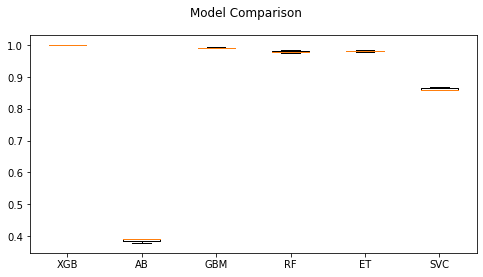

In [33]:
#Compare the model outcomes

fig = pyplot.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(8,4)
pyplot.show()

## 3.3.) Selecting Random Forest (or whichver tree method best), Calculating its Baseline 

In [34]:
#Estimate accuracy on training set

rf_model = RandomForestClassifier()

cv = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)
scores = cross_val_score(rf_model, X_train_scaled, y_train, scoring='accuracy', cv=cv)
avg_score = np.mean(scores)
avg_score

0.9796974844293457

In [35]:
#Estimate accuracy on validation set

rf_model = RandomForestClassifier()

rf_model.fit(X_train_scaled, y_train)

predictions = rf_model.predict(X_validation_scaled)

print(accuracy_score(y_validation, predictions))

print('Weighted Precision: {:.2f}'.format(precision_score(y_validation, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_validation, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_validation, predictions, average='weighted')))

print(classification_report(y_validation, predictions, target_names=["Strong Sell", "Sell", "Pass", "Buy", "Strong Buy", "Very High Return"]))

print(confusion_matrix(y_validation, predictions))

0.9941766418634747
Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99
                  precision    recall  f1-score   support

     Strong Sell       1.00      1.00      1.00      1225
            Sell       0.99      0.99      0.99       531
            Pass       0.98      0.97      0.97       100
             Buy       0.98      1.00      0.99       255
      Strong Buy       1.00      0.97      0.99       197
Very High Return       0.99      1.00      1.00       783

        accuracy                           0.99      3091
       macro avg       0.99      0.99      0.99      3091
    weighted avg       0.99      0.99      0.99      3091

[[1221    2    2    0    0    0]
 [   2  525    0    4    0    0]
 [   1    1   97    1    0    0]
 [   0    0    0  255    0    0]
 [   0    0    0    0  192    5]
 [   0    0    0    0    0  783]]


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

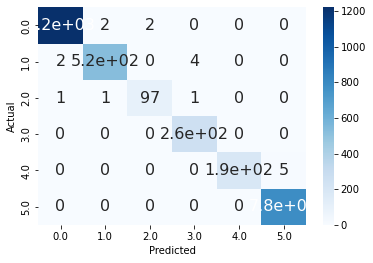

In [36]:
#Visualization of the Confusion Matrix

df_matrix = pd.DataFrame(confusion_matrix(y_validation, predictions), columns=np.unique(y_validation), index = np.unique(y_validation))
df_matrix.index.name = 'Actual'
df_matrix.columns.name = 'Predicted'
sns.heatmap(df_matrix, cmap="Blues", annot=True, annot_kws={"size": 16}) 

# SECTION 4: Model Tuning 

## 4.1.) Hyperparameter Tuning for Random Forest

### APPROACH (A) 
## __*(CAUTION TAKES A LONG TIME!)*__

In [ ]:


# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {}

paramgrid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

random.seed(1)

cv = EvolutionaryAlgorithmSearchCV(estimator=RandomForestClassifier(),
                                   params=paramgrid,
                                   scoring="accuracy",
                                   cv=StratifiedKFold(n_splits=4),
                                   verbose=1,
                                   population_size=50,
                                   gene_mutation_prob=0.10,
                                   gene_crossover_prob=0.5,
                                   tournament_size=3,
                                   generations_number=5,
                                   n_jobs=4)
cv.fit(X_train_scaled, y_train)

### APPROACH (B)
## __*(CAUTION TAKES A LONG TIME!)*__

In [ ]:
# Grid Search: (select model) Tuning

n_estimators = [20, 100, 180, 1000]
max_features = [1, 2, 3, 4]

param_grid = dict(n_estimators=n_estimators, max_features=max_features)

rf_model = RandomForestClassifier()

kfold = StratifiedKFold(n_splits=num_folds, random_state=seed, shuffle=True)

grid = GridSearchCV(estimator=rf_model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train_scaled, y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

### PROCEEDING WITH BEST APPROACH

In [37]:
#Prepare the model with parameters decided in previous cell

rf_model = RandomForestClassifier(max_features=3, n_estimators=20)
rf_model.fit(X_train_scaled, y_train)

RandomForestClassifier(max_features=3, n_estimators=20)

In [38]:
#Score predictions of training set

training_predictions = rf_model.predict(X_train_scaled)

print(accuracy_score(y_validation, predictions))

print('Micro Precision: {:.2f}'.format(precision_score(y_train, training_predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_train, training_predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_train, training_predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_train, training_predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_train, training_predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_train, training_predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_train, training_predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_train, training_predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_train, training_predictions, average='weighted')))


print(classification_report(y_train, training_predictions, target_names=["Strong Sell", "Sell", "Pass", "Buy", "Strong Buy", "Very High Return"]))

0.9941766418634747
Micro Precision: 1.00
Micro Recall: 1.00
Micro F1-score: 1.00

Macro Precision: 1.00
Macro Recall: 1.00
Macro F1-score: 1.00

Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00
                  precision    recall  f1-score   support

     Strong Sell       1.00      1.00      1.00      4953
            Sell       1.00      1.00      1.00      2199
            Pass       1.00      1.00      1.00       390
             Buy       1.00      1.00      1.00      1005
      Strong Buy       1.00      1.00      1.00       723
Very High Return       1.00      1.00      1.00      3093

        accuracy                           1.00     12363
       macro avg       1.00      1.00      1.00     12363
    weighted avg       1.00      1.00      1.00     12363



In [39]:
#Score predictions of validation set

predictions = rf_model.predict(X_validation_scaled)

print(accuracy_score(y_validation, predictions))

print('Micro Precision: {:.2f}'.format(precision_score(y_validation, predictions, average='micro')))
print('Micro Recall: {:.2f}'.format(recall_score(y_validation, predictions, average='micro')))
print('Micro F1-score: {:.2f}\n'.format(f1_score(y_validation, predictions, average='micro')))

print('Macro Precision: {:.2f}'.format(precision_score(y_validation, predictions, average='macro')))
print('Macro Recall: {:.2f}'.format(recall_score(y_validation, predictions, average='macro')))
print('Macro F1-score: {:.2f}\n'.format(f1_score(y_validation, predictions, average='macro')))

print('Weighted Precision: {:.2f}'.format(precision_score(y_validation, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_validation, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_validation, predictions, average='weighted')))


print(classification_report(y_validation, predictions, target_names=["Strong Sell", "Sell", "Pass", "Buy", "Strong Buy", "Very High Return"]))

print(confusion_matrix(y_validation, predictions))

0.987706243934002
Micro Precision: 0.99
Micro Recall: 0.99
Micro F1-score: 0.99

Macro Precision: 0.98
Macro Recall: 0.97
Macro F1-score: 0.98

Weighted Precision: 0.99
Weighted Recall: 0.99
Weighted F1-score: 0.99
                  precision    recall  f1-score   support

     Strong Sell       0.99      1.00      0.99      1225
            Sell       0.99      0.99      0.99       531
            Pass       0.98      0.94      0.96       100
             Buy       0.98      0.97      0.98       255
      Strong Buy       0.97      0.94      0.96       197
Very High Return       0.99      1.00      0.99       783

        accuracy                           0.99      3091
       macro avg       0.98      0.97      0.98      3091
    weighted avg       0.99      0.99      0.99      3091

[[1220    3    2    0    0    0]
 [   5  524    0    2    0    0]
 [   2    3   94    1    0    0]
 [   1    1    0  248    5    0]
 [   0    0    0    2  186    9]
 [   1    0    0    0    1  781]]


<AxesSubplot:xlabel='Predicted', ylabel='Actual'>

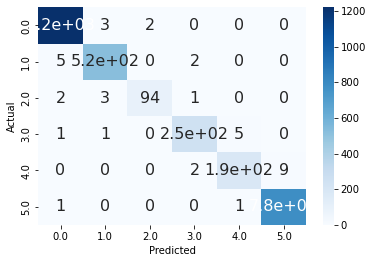

In [40]:
#Visualization of the Confusion Matrix

df_matrix = pd.DataFrame(confusion_matrix(y_validation, predictions), columns=np.unique(y_validation), index = np.unique(y_validation))
df_matrix.index.name = 'Actual'
df_matrix.columns.name = 'Predicted'
sns.heatmap(df_matrix, cmap="Blues", annot=True, annot_kws={"size": 16}) 

## 4.2.) Determining Feature Importance

In [41]:
#Feature importances

importances = rf_model.feature_importances_

In [42]:
important_features = zip(X.columns, rf_model.feature_importances_)

In [43]:
importances_df = pd.DataFrame(important_features)

In [44]:
importances_df = importances_df.rename(columns={0: 'Feature', 1: 'Importance'})

In [45]:
importances_df = importances_df.set_index('Feature')

In [46]:
importances_df = importances_df.sort_values(by='Importance', ascending=False)

In [47]:
importances_df

,Importance
Feature,
STRIKE,0.176602
PRICEOPEN,0.139916
SPY PRICE,0.131025
VIX PRICE,0.094321
INFLATION%,0.090851
C_DELTA,0.072004
STRIKE DISTANCE,0.067443
C_GAMMA,0.051485
C_THETA,0.049299


<AxesSubplot:title={'center':'Feature Importance'}, ylabel='Feature'>

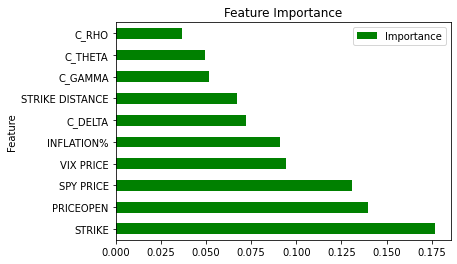

In [48]:
#Plot the top 10 most important features

importances_df[0:10].plot(
    kind='barh',
    color='green',
    title='Feature Importance',
    legend=True)

## 4.2. Bayesian Optimization with HYPEROPT for XRG

## __*(CAUTION TAKES A COUPLE OF MIN!)*__

In [49]:
#Initialize domain space for range of values 
 
space={'max_depth': hp.quniform("max_depth", 3, 18, 1),
        'gamma': hp.uniform ('gamma', 1, 9),
        'reg_alpha' : hp.quniform('reg_alpha', 40, 180, 1),
        'reg_lambda' : hp.uniform('reg_lambda', 0, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': 180,
        'seed': 0
    }


The available hyperopt optimization algorithms are -

hp.choice(label, options) — Returns one of the options, which should be a list or tuple.

hp.randint(label, upper) — Returns a random integer between the range [0, upper).

hp.uniform(label, low, high) — Returns a value uniformly between low and high.

hp.quniform(label, low, high, q) — Returns a value round(uniform(low, high) / q) * q, i.e it rounds the decimal values and returns an integer.

hp.normal(label, mean, std) — Returns a real value that’s normally-distributed with mean and standard deviation sigma.

In [50]:
def objective(space):
    xgb_model = xgb.XGBClassifier(
                    n_estimators =space['n_estimators'], max_depth = int(space['max_depth']), gamma = space['gamma'],
                    reg_alpha = int(space['reg_alpha']),min_child_weight=int(space['min_child_weight']),
                    colsample_bytree=int(space['colsample_bytree']))
    
    evaluation = [(X_train_scaled, y_train), (X_validation_scaled, y_validation)]
    
    xgb_model.fit(X_train_scaled, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=10,verbose=False)
    

    pred = xgb_model.predict(X_validation_scaled)
    accuracy = accuracy_score(y_validation, pred>0.5)
    print ("SCORE:", accuracy)
    return {'loss': -accuracy, 'status': STATUS_OK }

In [51]:
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 100,
                        trials = trials)

SCORE:                                                                          
0.47719184729860886                                                             
SCORE:                                                                          
0.5059851180847622                                                              
SCORE:                                                                          
0.4383694597217729                                                              
SCORE:                                                                          
0.4364283403429311                                                              
SCORE:                                                                          
0.4746036881268198                                                              
SCORE:                                                                          
0.45325137495956                                                                
SCORE:                      

In [54]:
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

The best hyperparameters are :  

{'colsample_bytree': 0.764022574054172, 'gamma': 1.0553890243127433, 'max_depth': 5.0, 'min_child_weight': 8.0, 'reg_alpha': 40.0, 'reg_lambda': 0.3877400029267476}


In [55]:
#Establish XGB model instance
#Fitting training dataset to model

xgb_model = xgb.XGBClassifier()  #(colsample_bytree=0.6686069756622127, max_depth=17, gamma=1.3673617773715256, min_child_weight=2, reg_lambda=0.214836520311216, reg_alpha=0)
xgb_model.fit(X_train_scaled, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, objective='multi:softprob',
              predictor='auto', random_state=0, reg_alpha=0, ...)

In [56]:
#Predicting on training set

training_predictions = xgb_model.predict(X_train_scaled)

print(accuracy_score(y_train, training_predictions))

print('Weighted Precision: {:.2f}'.format(precision_score(y_train, training_predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_train, training_predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_train, training_predictions, average='weighted')))

print(classification_report(y_train, training_predictions, target_names=["Strong Sell", "Sell", "Pass", "Buy", "Strong Buy", "Very High Return"]))

1.0
Weighted Precision: 1.00
Weighted Recall: 1.00
Weighted F1-score: 1.00
                  precision    recall  f1-score   support

     Strong Sell       1.00      1.00      1.00      4953
            Sell       1.00      1.00      1.00      2199
            Pass       1.00      1.00      1.00       390
             Buy       1.00      1.00      1.00      1005
      Strong Buy       1.00      1.00      1.00       723
Very High Return       1.00      1.00      1.00      3093

        accuracy                           1.00     12363
       macro avg       1.00      1.00      1.00     12363
    weighted avg       1.00      1.00      1.00     12363



In [ ]:
#Predicting on validation set

predictions = xgb_model.predict(X_validation_scaled)

print(accuracy_score(y_validation, predictions))

print('Weighted Precision: {:.2f}'.format(precision_score(y_validation, predictions, average='weighted')))
print('Weighted Recall: {:.2f}'.format(recall_score(y_validation, predictions, average='weighted')))
print('Weighted F1-score: {:.2f}'.format(f1_score(y_validation, predictions, average='weighted')))

print(classification_report(y_validation, predictions, target_names=["Strong Sell", "Sell", "Pass", "Buy", "Strong Buy", "Very High Return"]))

print(confusion_matrix(y_validation, predictions))

In [ ]:
#Get probabilities of predictions

pred_proba = xgb_model.predict_proba(X_validation_scaled)
pred_proba

In [ ]:
proba_df = pd.DataFrame(pred_proba.round(2))

In [ ]:
#Formatting probabilities DataFrame

proba_df["Actual"] = y_validation
proba_df.columns = ["'Strong Sell' Probability", "'Sell' Probability", "'Pass' Probability", "'Buy' Probability", "'Strong Buy' Probability", "'Very High Return' Prob.", "Actual"]
proba_df

In [ ]:
#Labeling caterogires

proba_df.loc[proba_df["Actual"] == 0, "Actual"] = "Strong Sell"
proba_df.loc[proba_df["Actual"] == 1, "Actual"] = "Sell"
proba_df.loc[proba_df["Actual"] == 2, "Actual"] = "Pass"
proba_df.loc[proba_df["Actual"] == 3, "Actual"] = "Buy"
proba_df.loc[proba_df["Actual"] == 4, "Actual"] = "Strong Buy"
proba_df.loc[proba_df["Actual"] == 5, "Actual"] = "Very High Return"

proba_df

In [ ]:
#Get ROC AUC score

roc_auc_score(y_validation, pred_proba, multi_class="ovr")

## 4.2.) Determining Feature Importance for XGBoost Model

In [ ]:
#Feature importances

importances = xgb_model.feature_importances_

In [ ]:
important_features = zip(X.columns, xgb_model.feature_importances_)

In [ ]:
importances_df = pd.DataFrame(important_features)

In [ ]:
importances_df = importances_df.rename(columns={0: 'Feature', 1: 'Importance'})

In [ ]:
importances_df = importances_df.set_index('Feature')

In [ ]:
importances_df = importances_df.sort_values(by='Importance', ascending=False)

In [ ]:
importances_df

In [ ]:
#Plot the top 10 most important features

importances_df[0:10].plot(
    kind='barh',
    color='green',
    title='Feature Importance',
    legend=True)

In [ ]:
#et_model = ExtraTreesClassifier()
#et_model.fit(X_train_scaled, y_train)

In [ ]:
#ab_model = AdaBoostClassifier()
#ab_model.fit(X_train_scaled, y_train)

In [53]:
#gb_model = GradientBoostingClassifier()
#ab_model.fit(X_train_scaled, y_train)